In [ ]:
import os
import shutil
import soundfile as sf
import pandas as pd
from plc_mos import PLCMOSEstimator
import wave

In [ ]:
PACKET_LOSS_TOOL_DIR = "/home/dangnp/workspace/tools/loss-simulator/frontend/loss-simulator/public/audio"
AUDIO_RECORDING_DIR = "./audio"
REFORMATTED_DIR = "./score"

MIN_AUDIO_DURATION = 20
MAX_AUDIO_DURATION_OFFSET = 2
AUDIO_FILE_NAME = [
                    "plc", 
                    "normal", 
                   "plc-opus_1.5"
                   ]
AUDIO_FILE_TYPE = ".wav"
EVAL_COMPLEXITY = [2,3,4,5,6,7,8,9,10]

SCORE_OUTPUT_FILE_NAME = "output.xlsx"
TMP_SCORE_OUTPUT_FILE_NAME = "tmp.xlsx"

### Manual

In [ ]:
# COMPLEXITY = 9
# OPUS_PLC_SAMPLE_DIR = "./audio-opusPlc-com" + str(COMPLEXITY)
# NORMAL_SAMPLE_DIR = "./audio-normal-com" + str(COMPLEXITY)
# SCORED_AUDIO_DIR = "./scored-audio-com" + str(COMPLEXITY) 

# NETWORK_TYPE = ["3g", "4g"]
# LOSS_PERCENTAGE = ["0", "10", "30", "50", "70", "90"]
# AUDIO_FILE_NAME = ["opusPlc", "normal"]
# AUDIO_FILE_TYPE = ".wav"


# shutil.copytree(PACKET_LOSS_TOOL_DIR, OPUS_PLC_SAMPLE_DIR, dirs_exist_ok=True)
# shutil.copytree(PACKET_LOSS_TOOL_DIR, NORMAL_SAMPLE_DIR, dirs_exist_ok=True)

- Create audio folder

In [ ]:
# def genAudioFiles(audioType = AUDIO_FILE_NAME[0]):
#     counter = 0
#     if audioType == AUDIO_FILE_NAME[0]:
#         baseDir = OPUS_PLC_SAMPLE_DIR
#     else:
#         baseDir = NORMAL_SAMPLE_DIR
#     sampleFolder = os.listdir(baseDir)
#     sampleFolder.sort()
#     for folder in sampleFolder:
#         print(f"Processing {folder} ...")
#         folderPath = baseDir + "/" + folder
#         target = folderPath + "/" + [file for file in os.listdir(folderPath) if file.startswith("speaker")][0]
#         network = NETWORK_TYPE[counter // len(LOSS_PERCENTAGE)]
#         loss = LOSS_PERCENTAGE[counter % len(LOSS_PERCENTAGE)]
#         dest = SCORED_AUDIO_DIR + "/" + f"{network}-loss{loss}"
#         filename = audioType + AUDIO_FILE_TYPE
#         os.makedirs(dest, exist_ok=True)

#         shutil.copyfile(target, dest + "/" + filename)
#         counter += 1

In [ ]:
# genAudioFiles(AUDIO_FILE_NAME[0])
# genAudioFiles(AUDIO_FILE_NAME[1])

- PLCMOS Scoring

    - Sample:

In [ ]:
# plcmos = PLCMOSEstimator()
# data, sr = sf.read("./example_wavs/clean.wav")
# mos = plcmos.run(data, sr)
# mos

    - Scoring:

In [ ]:
# rows = []
# plc = []
# normal = []

In [ ]:
# for networkType in os.listdir(SCORED_AUDIO_DIR):
#     rows.append(networkType)
#     networkPath = SCORED_AUDIO_DIR + "/" + networkType
    
#     plcFilePath = networkPath + "/" + AUDIO_FILE_NAME[0] + AUDIO_FILE_TYPE
#     data, sr = sf.read(plcFilePath)
#     print(plcFilePath)
#     mos = plcmos.run(data, sr)
#     plc.append(mos)

#     normalFilePath = networkPath + "/" + AUDIO_FILE_NAME[1] + AUDIO_FILE_TYPE
#     data, sr = sf.read(normalFilePath)
#     print(normalFilePath)
#     mos = plcmos.run(data, sr)
#     normal.append(mos)

    - Export to excel:

In [ ]:
# df = pd.DataFrame({"Network Condition": rows, AUDIO_FILE_NAME[0]: plc, AUDIO_FILE_NAME[1]: normal, "diff (opusPlc - normal)": (pd.Series(plc) - pd.Series(normal))})
# df = df.set_index("Network Condition")
# df = df.sort_index()
# df.to_excel(f"output-{COMPLEXITY}.xlsx", sheet_name="Complexity" + str(COMPLEXITY))
# df

### Auto gen

In [ ]:
processedTestcases = {}

In [ ]:
shutil.copytree(PACKET_LOSS_TOOL_DIR, AUDIO_RECORDING_DIR, dirs_exist_ok=True)

- Re-format audio folder:

``` complex -> network type -> loss -> (normal | plc) .wav ```

In [ ]:
processedTestcases = {}
def getAudioDuration(filePath: str) -> float:
        try:
            with wave.open(filePath, "rb") as wavFile:
                frames = wavFile.getnframes()
                rate = wavFile.getframerate()
                duration = frames / float(rate)
            return round(duration, 2)
        except:
            return -1

def reformatAudioFolder(audioFolder, generatedFolderName, minAudioDuration = MIN_AUDIO_DURATION, offset = MAX_AUDIO_DURATION_OFFSET, isOpus1_5 = False):
    os.makedirs(generatedFolderName, exist_ok=True)
    subDirectories = os.listdir(audioFolder)

    for dir in subDirectories:
        targetFiles = [f for f in os.listdir(
            os.path.join(audioFolder, dir)
        ) if f.startswith("speak") and f.endswith(".wav")]

        for audio in targetFiles.copy():
            audioFilePath = os.path.join(audioFolder, dir, audio)
            if getAudioDuration(audioFilePath) < minAudioDuration - offset:
                targetFiles.remove(audio)

        if (len(targetFiles) <= 0) : continue


        params = dir.split("_")
        curCom = params[0].lower()
        curCallType = (params[1] if not isOpus1_5 or params[1] == "normal" else AUDIO_FILE_NAME[-1]).lower()
        curNetwork = params[2].split("loss")
        curNetworkType = curNetwork[0].lower()
        curNetworkLoss = int(curNetwork[1])

        curPath = os.path.join(generatedFolderName, curCom, curNetworkType, f"loss_{curNetworkLoss}")
        os.makedirs(exist_ok=True, name=curPath)
        curPath = os.path.join(curPath, curCallType + ".wav")

        # if current condition already processed before -> duplicate -> Raise Error
        if curPath in processedTestcases:
            print(f"Already generated testcase for {curPath}\nwith current dir: {dir}\nand previous dir: {processedTestcases[curPath]}")
            continue
        # print(f"Copy {curPath}")
        shutil.copy2(
            os.path.join(
                audioFolder, 
                dir,
                targetFiles[0]
            ), 
            curPath
        )
        processedTestcases[curPath + "_opus1.5" + str(isOpus1_5)] = dir


reformatAudioFolder(audioFolder=AUDIO_RECORDING_DIR, generatedFolderName=REFORMATTED_DIR)

In [ ]:
processedTestcases = {}
reformatAudioFolder(audioFolder='./audio-attemp2-normal-plc-1.3', generatedFolderName=REFORMATTED_DIR)

In [ ]:
# opus1.5 PLC
processedTestcases = {}
shutil.copytree(PACKET_LOSS_TOOL_DIR, AUDIO_RECORDING_DIR, dirs_exist_ok=True)
reformatAudioFolder(AUDIO_RECORDING_DIR, REFORMATTED_DIR, isOpus1_5=True)

    - Scoring

In [ ]:
def scoringcomplexity(
    complexity,
    sourceDir=REFORMATTED_DIR,
    targetAudioFiles=AUDIO_FILE_NAME,
    audioType=AUDIO_FILE_TYPE,
    outputFile=SCORE_OUTPUT_FILE_NAME
):
    plcmos = PLCMOSEstimator()
    rows, plc, normal = [], [], []

    sourceDir = os.path.join(sourceDir, f"com{complexity}")
    networkTypeDirs = os.listdir(sourceDir)
    networkTypeDirs.sort()
    for networkType in networkTypeDirs:
        lossDirs = os.listdir(
            os.path.join(
                sourceDir,
                networkType
            )
        )
        lossDirs.sort(key=lambda x: int(x.split("_")[-1]))
        for loss in lossDirs:
            rows.append(f"{networkType}-{loss}")
            networkPath = os.path.join(sourceDir, networkType, loss)

            # plc
            plcFilePath = os.path.join(networkPath, targetAudioFiles[0] + audioType)
            data, sr = sf.read(plcFilePath)
            mos = plcmos.run(data, sr)
            print(plcFilePath, mos)
            plc.append(mos)

            # normal
            normalFilePath = os.path.join(networkPath, targetAudioFiles[1] + audioType)
            data, sr = sf.read(normalFilePath)
            mos = plcmos.run(data, sr)
            print(normalFilePath, mos)
            normal.append(mos)

    df = pd.DataFrame({
        "Network Condition": rows,
        targetAudioFiles[0]: plc,
        targetAudioFiles[1]: normal
    }).set_index("Network Condition")

    if os.path.exists(outputFile):
        with pd.ExcelWriter(outputFile, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
            df.to_excel(writer, sheet_name=f"complexity {complexity}")
    else:
        with pd.ExcelWriter(outputFile, mode="w", engine="openpyxl") as writer:
            df.to_excel(writer, sheet_name=f"complexity {complexity}")


In [ ]:
def scoringcomplexityAll(
    complexity,
    sourceDir=REFORMATTED_DIR,
    targetAudioFiles=AUDIO_FILE_NAME,
    audioType=AUDIO_FILE_TYPE,
    outputFile=SCORE_OUTPUT_FILE_NAME
):
    plcmos = PLCMOSEstimator()
    rows = []
    scores = {name: [] for name in targetAudioFiles}  # store results for each file

    sourceDir = os.path.join(sourceDir, f"com{complexity}")
    networkTypeDirs = os.listdir(sourceDir)
    networkTypeDirs.sort()

    for networkType in networkTypeDirs:
        lossDirs = os.listdir(os.path.join(sourceDir, networkType))
        lossDirs.sort(key=lambda x: int(x.split("_")[-1]))

        for loss in lossDirs:
            rows.append(f"{networkType}-{loss}")
            networkPath = os.path.join(sourceDir, networkType, loss)

            for fileName in targetAudioFiles:
                filePath = os.path.join(networkPath, fileName + audioType)
                data, sr = sf.read(filePath)
                mos = plcmos.run(data, sr)
                print(filePath, mos)
                scores[fileName].append(mos)

    # Build DataFrame dynamically with all audio types as columns
    df_dict = {"Network Condition": rows}
    df_dict.update(scores)
    df = pd.DataFrame(df_dict).set_index("Network Condition")

    # Save into Excel
    if os.path.exists(outputFile):
        with pd.ExcelWriter(outputFile, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
            df.to_excel(writer, sheet_name=f"complexity {complexity}")
    else:
        with pd.ExcelWriter(outputFile, mode="w", engine="openpyxl") as writer:
            df.to_excel(writer, sheet_name=f"complexity {complexity}")


In [ ]:
# opus1.5 plc
plcmos = PLCMOSEstimator()

def scoringcomplexityOpus1_5(
    complexity,
    sourceDir=REFORMATTED_DIR,
    targetAudioFiles=AUDIO_FILE_NAME,
    audioType=AUDIO_FILE_TYPE,
    outputFile=SCORE_OUTPUT_FILE_NAME
):
    rows, plc, normal = [], [], []

    sourceDir = os.path.join(sourceDir, f"com{complexity}")
    networkTypeDirs = os.listdir(sourceDir)
    networkTypeDirs.sort()
    for networkType in networkTypeDirs:
        lossDirs = os.listdir(
            os.path.join(
                sourceDir,
                networkType
            )
        )
        lossDirs.sort(key=lambda x: int(x.split("_")[-1]))
        for loss in lossDirs:
            rows.append(f"{networkType}-{loss}")
            networkPath = os.path.join(sourceDir, networkType, loss)

            # plc
            plcOpus1_5FilePath = os.path.join(networkPath, targetAudioFiles[-1] + audioType)
            data, sr = sf.read(plcOpus1_5FilePath)
            mos = plcmos.run(data, sr)
            print(plcOpus1_5FilePath, mos)
            plc.append(mos)

    df = pd.DataFrame({
        "Network Condition": rows,
        targetAudioFiles[-1]: plc,
    }).set_index("Network Condition")

    if os.path.exists(outputFile):
        with pd.ExcelWriter(outputFile, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
            df.to_excel(writer, sheet_name=f"opus_1.5 complexity {complexity}")
    else:
        with pd.ExcelWriter(outputFile, mode="w", engine="openpyxl") as writer:
            df.to_excel(writer, sheet_name=f"opus_1.5 complexity {complexity}")


In [ ]:
# for complexity in EVAL_COMPLEXITY:
#     scoringcomplexityOpus1_5(complexity)

In [ ]:
for complexity in EVAL_COMPLEXITY:
    scoringcomplexity(complexity, outputFile=TMP_SCORE_OUTPUT_FILE_NAME)
#     scoringcomplexityAll(complexity)


# scoringcomplexity(10)

In [ ]:
with sf.SoundFile('/home/dangnp/workspace/tools/loss-simulator/frontend/loss-simulator/public/audio/com2_plc_3g-goodloss40_03-10-2025_231154/speaker_251003_231213.wav') as f:
            frames = len(f)
            print(f)

In [ ]:
import soundfile as sf

def getAudioDuration(filePath: str) -> float:
    with sf.SoundFile(filePath) as f:
        frames = len(f)             # total frames (better than f.frames)
        rate = f.samplerate
        duration = frames / float(rate)
    return round(duration, 2)

print(getAudioDuration("/home/dangnp/workspace/tools/loss-simulator/frontend/loss-simulator/public/audio/com2_plc_3g-goodloss40_03-10-2025_231154/speaker_251003_231213.wav"))


In [ ]:
plcmos = PLCMOSEstimator()
data, sr = sf.read("/home/dangnp/workspace/tools/loss-simulator/frontend/loss-simulator/public/audio/com2_plc_3g-goodloss40_03-10-2025_231154/speaker_251003_231213.wav")
mos = plcmos.run(data, sr)
mos

### CPU-MEM Usage boxplots

In [ ]:
OPUS_V_1_3_STAT_FOLDER = "/home/dangnp/workspace/cpu-ram-log-opus1.3"
OPUS_V_1_5_STAT_FOLDER = "/home/dangnp/workspace/cpu-ram-log-opus1.5"
STAT_TYPE = ["cpu", "mem"]

In [16]:
def getStatArray(complexity=5, mode="plc", type="cpu", version="1.3"):
    targetFolder = ""
    match version:
        case "1.3":
            targetFolder = OPUS_V_1_3_STAT_FOLDER
        case "1.5":
            targetFolder = OPUS_V_1_5_STAT_FOLDER
        case _:
            print(f"Get Failed: opus version {version} not exist!")
            return
    
    if complexity > 10 or complexity < 0:
        print(f"Get Failed: opus complexity {complexity} not exist!")
    
    complexity = f"com{complexity}"

    match mode:
        case "normal":
            mode = "n"
        case "plc":
            mode = "plc"
        case _:
            print(f"Get Failed: opus mode {mode} not exist!")
            return
        
    if type not in STAT_TYPE:
        print(f"Get Failed: Type {type} not defined!")
    

    files = [
        os.path.abspath(
            targetFolder + "/" + f"{complexity}-{mode}" +"/" + f 
        )
        for f in os.listdir(targetFolder + "/" + f"{complexity}-{mode}") 
        if f.startswith(type)
    ]
    


    if (len(files) < 0):
        print(f"Get Failed: There is no stat file for {version}-{complexity}-{mode}-{type}!")
    
    res = []
    for f in files:
        with open(f, "r") as reader:
            for line in reader:
                try:
                    val = float(line.strip())
                    if not val or val < 0:
                        continue
                    
                    res.append(val)
                except:
                    continue

    
    return res
        
    

In [20]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 5.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 5.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [31]:
import matplotlib.pyplot as plt
def drawBoxPlot(data, complex, type, mode, version):

    fig, ax = plt.subplots()
    bplot = ax.boxplot([data], patch_artist=True, labels=[type])

    # Add color
    match type:
        case "cpu":
            bplot['boxes'][0].set_facecolor('aquamarine')
        case "mem":
            bplot['boxes'][0].set_facecolor('peachpuff')
        case "_":
            return
    bplot['boxes'][0].set_facecolor('aquamarine')
    plt.savefig(f"{version}/{type}/{mode}/com{complex}.png", dpi=300, bbox_inches='tight')

/tmp/ipykernel_901289/1029344151.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot([data], patch_artist=True, labels=[type])
/tmp/ipykernel_901289/1029344151.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot([data], patch_artist=True, labels=[type])
/tmp/ipykernel_901289/1029344151.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot([data], patch_artist=True, labels=[type])
/tmp/ipykernel_901289/1029344151.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will

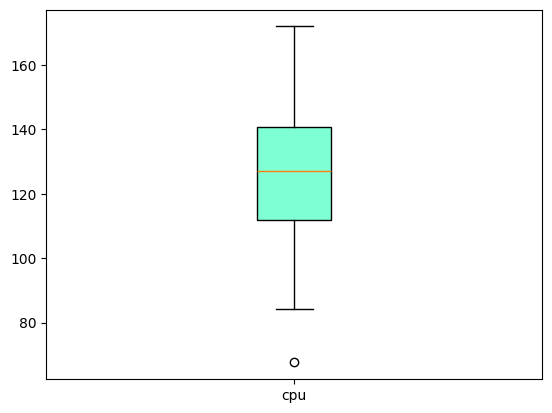

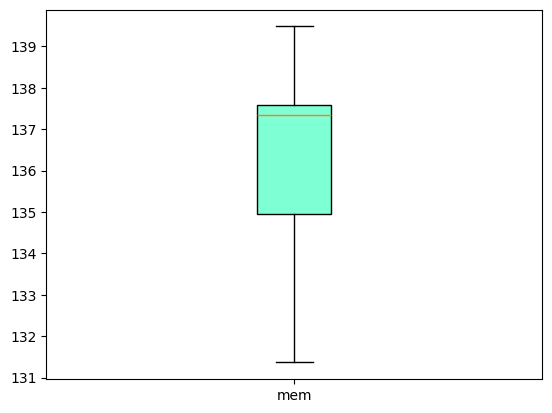

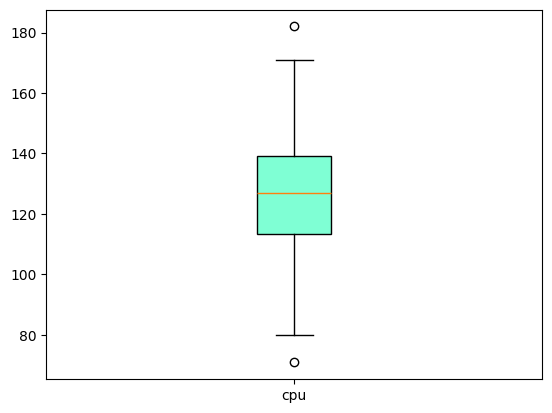

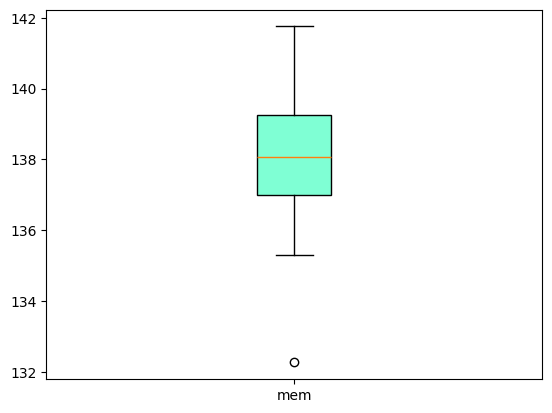

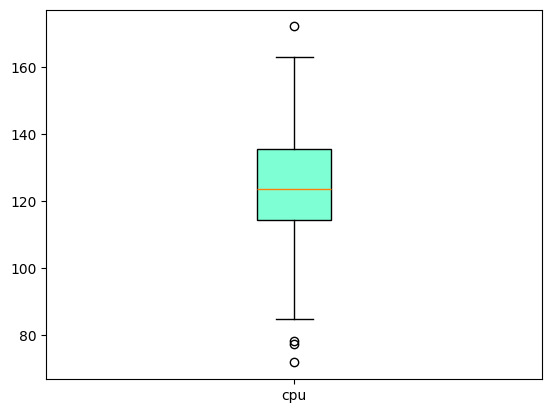

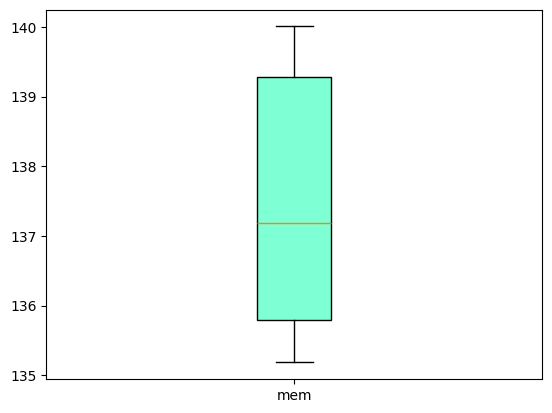

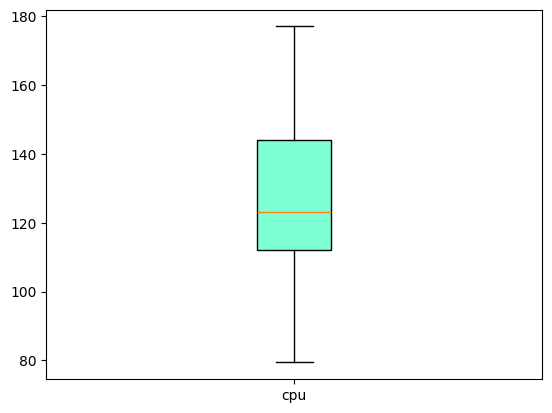

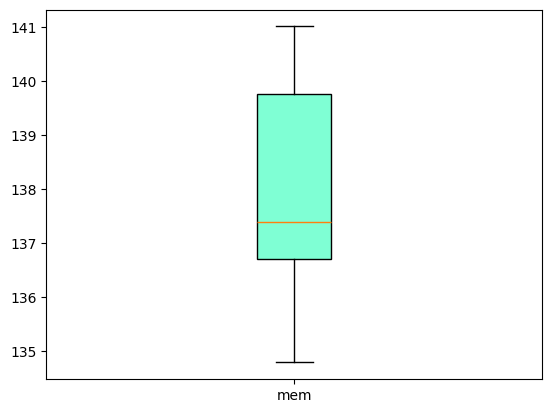

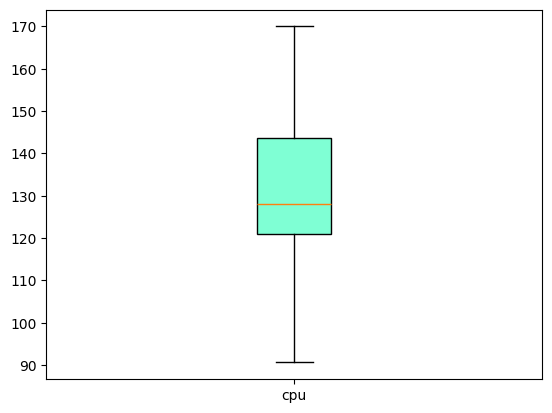

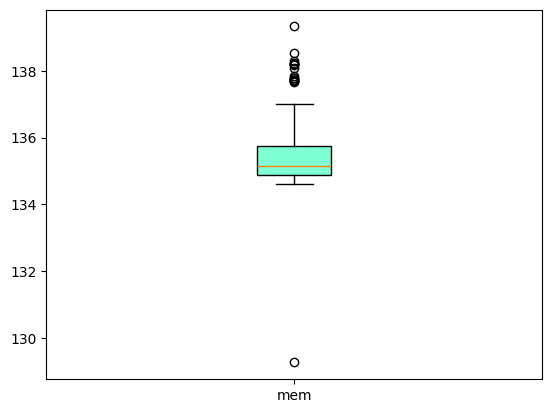

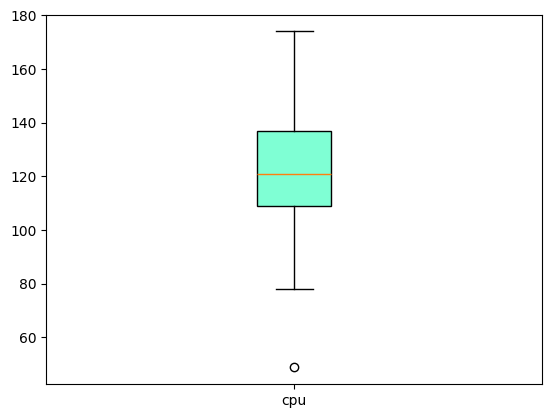

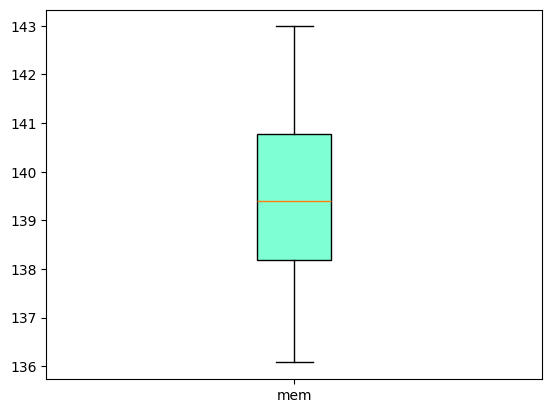

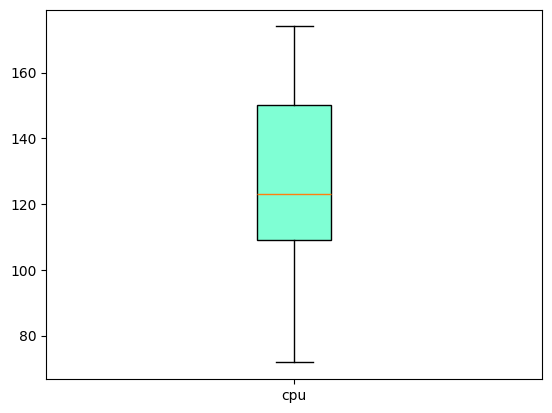

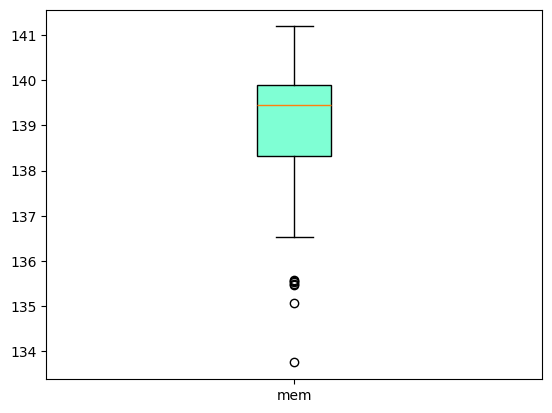

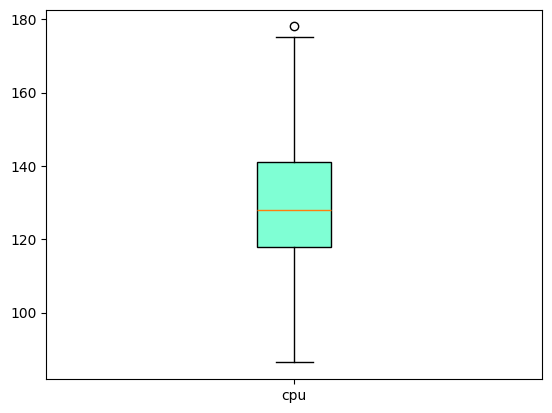

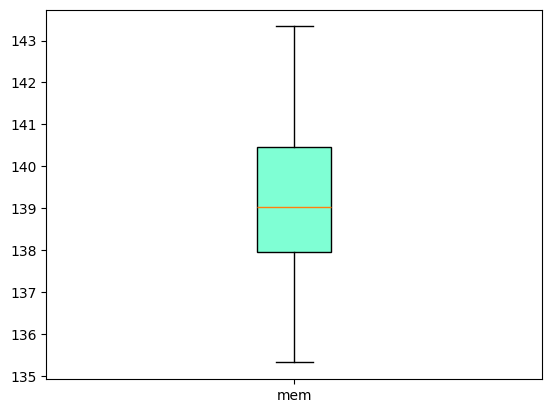

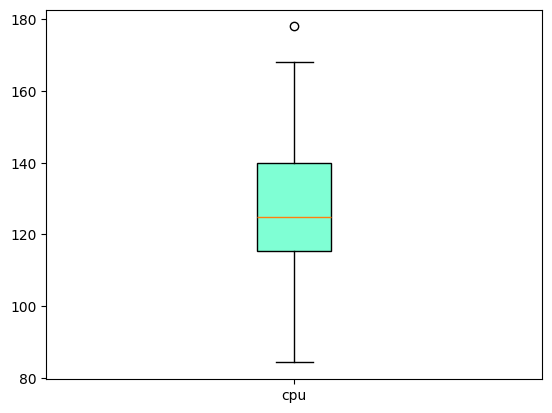

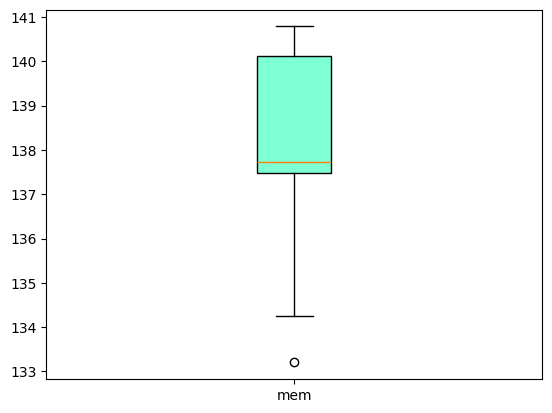

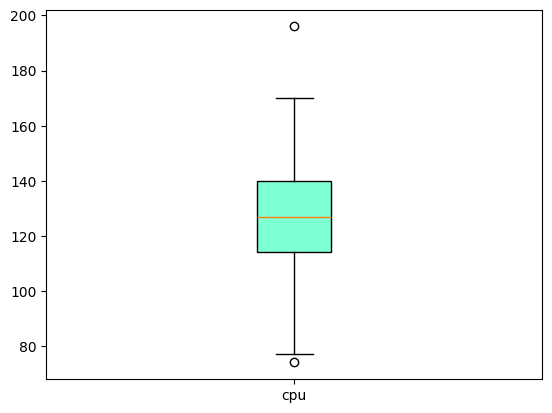

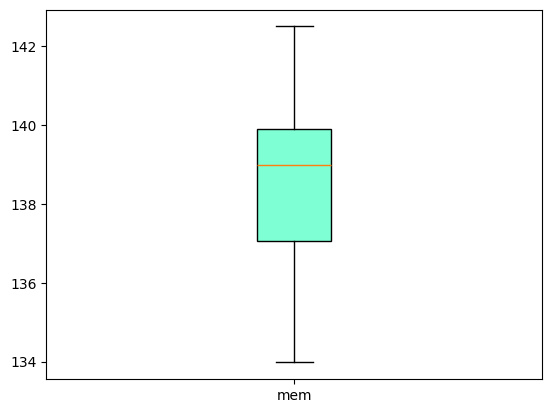

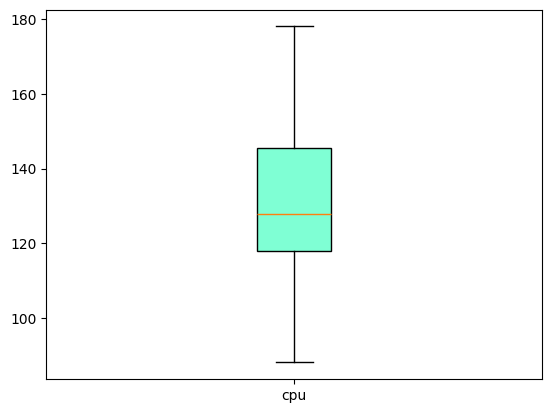

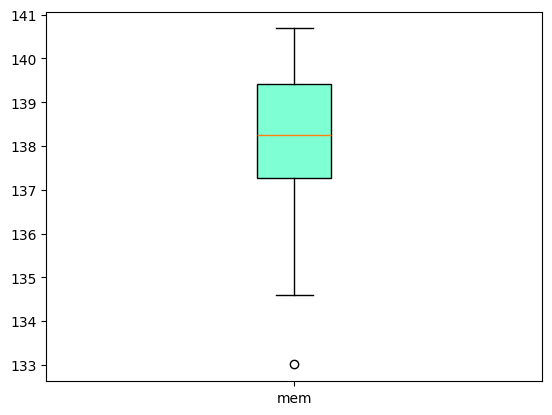

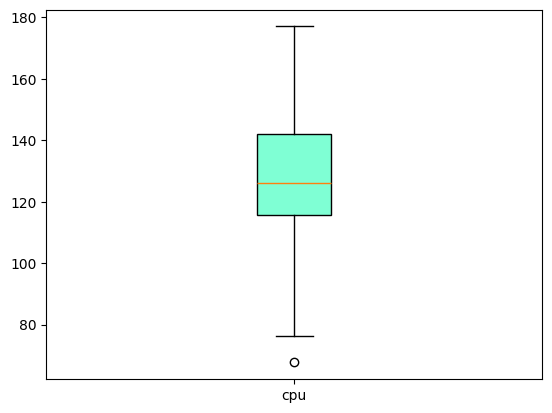

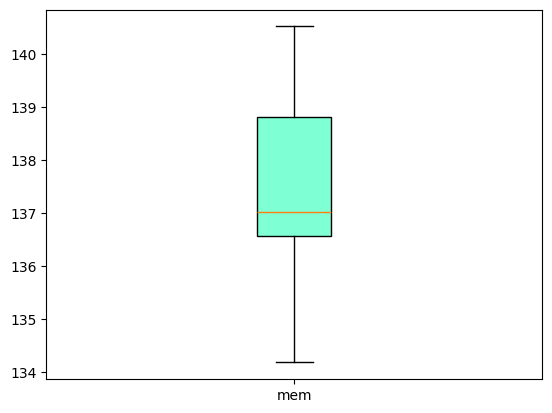

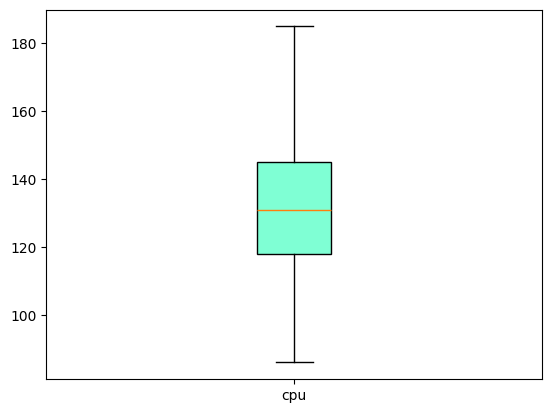

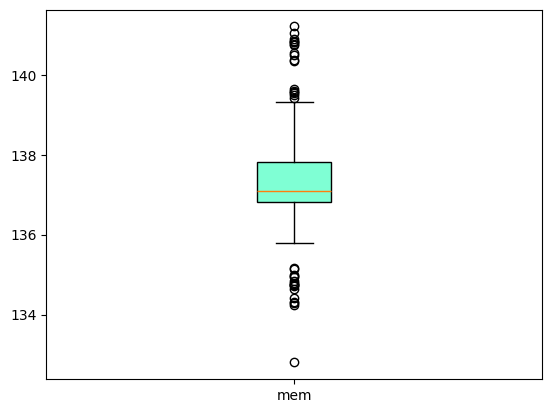

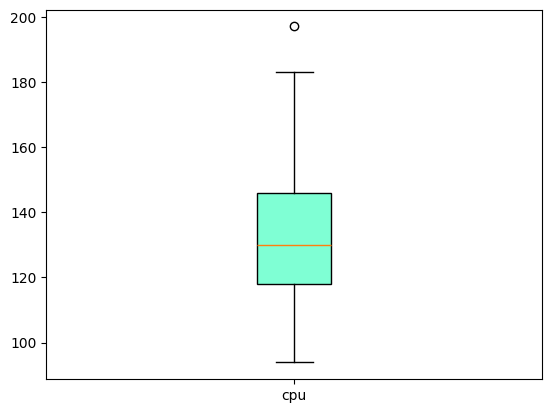

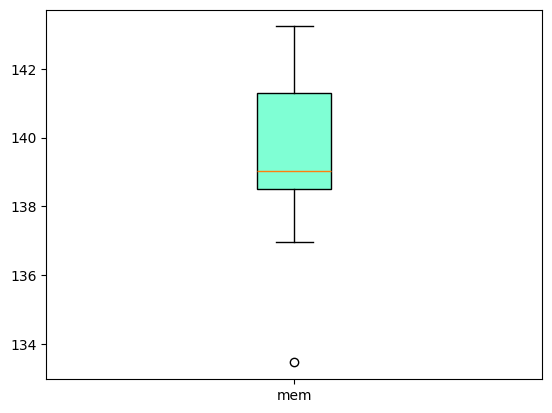

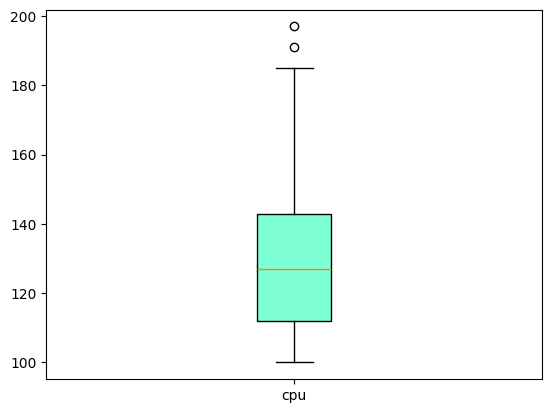

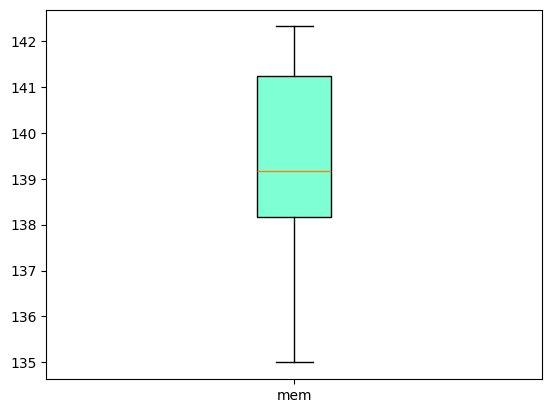

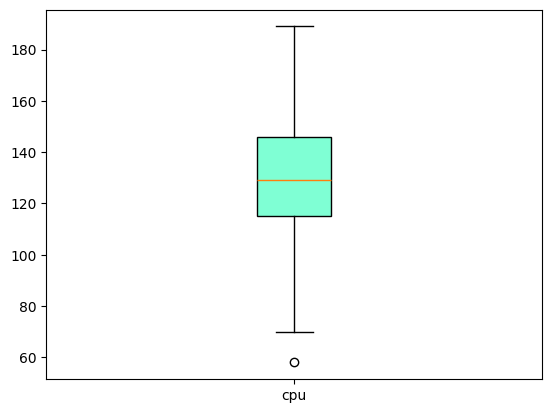

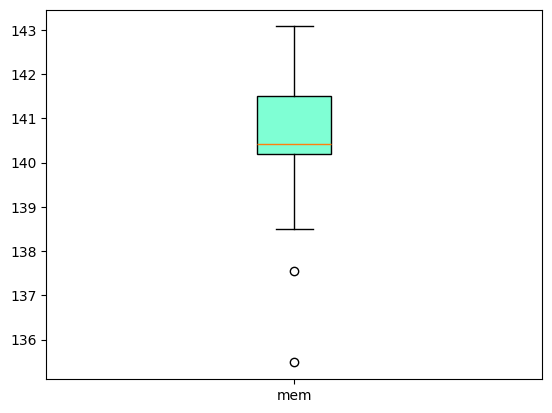

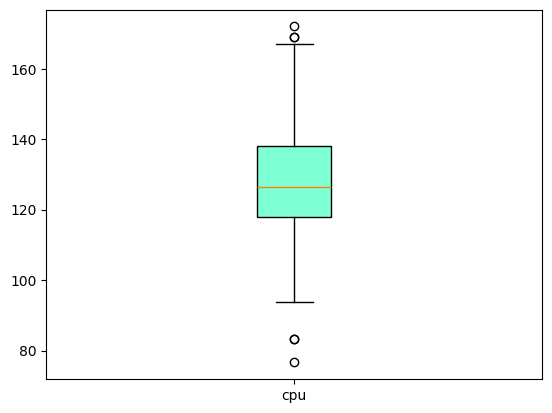

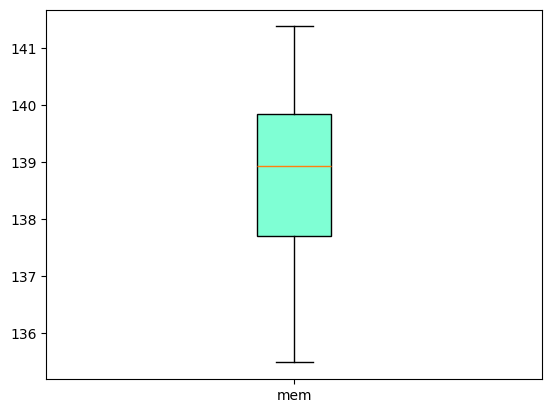

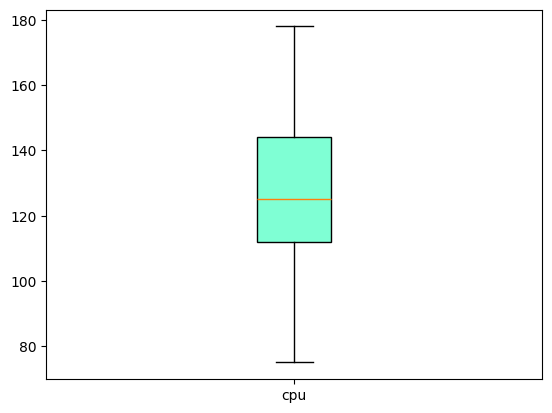

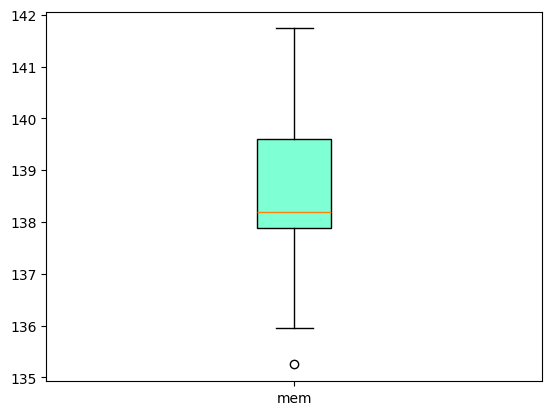

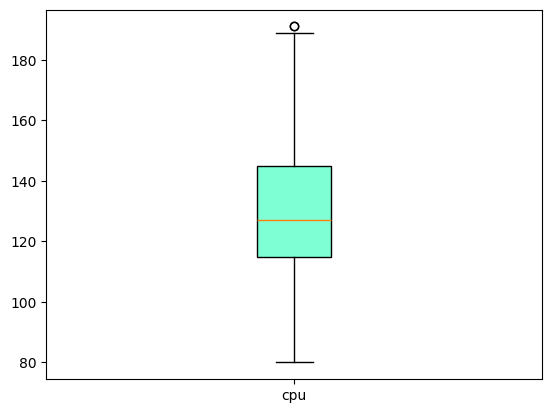

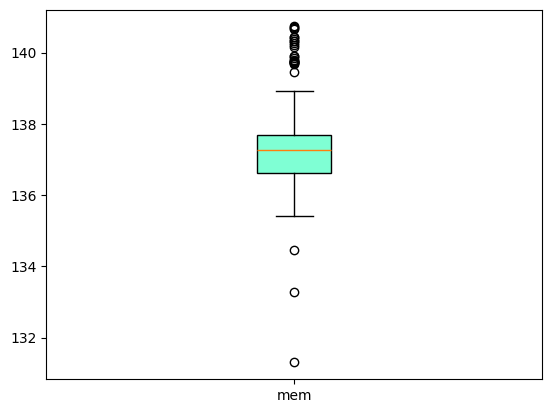

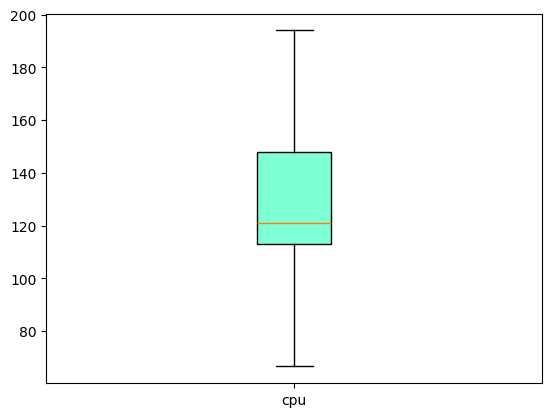

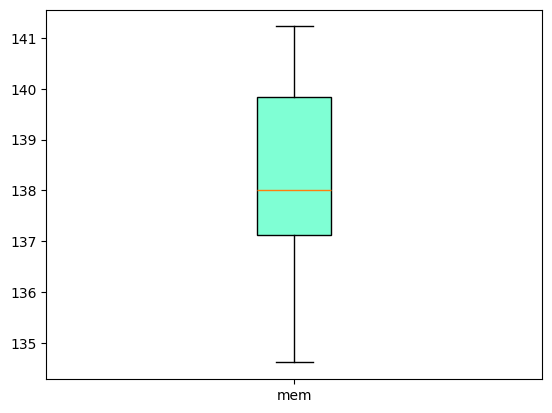

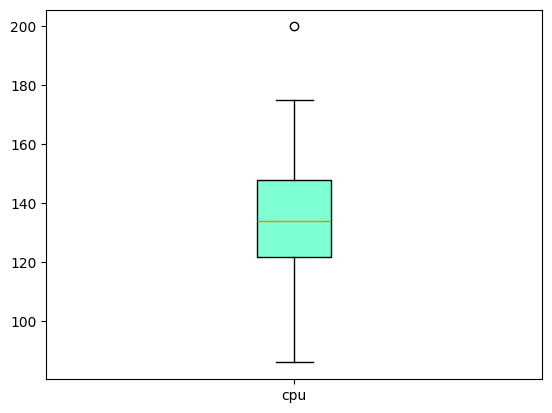

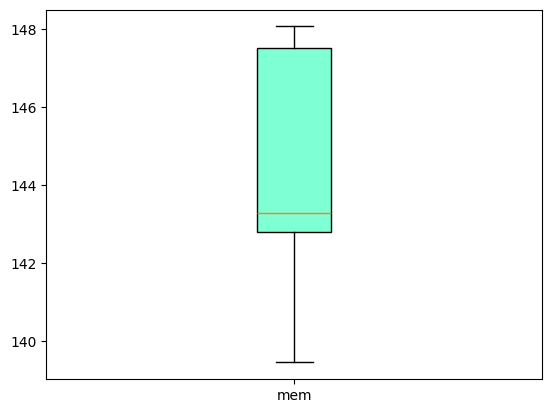

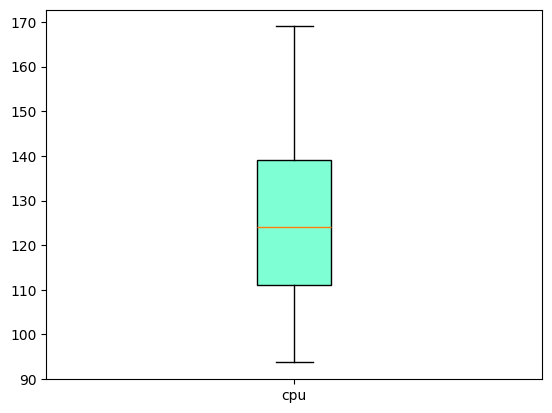

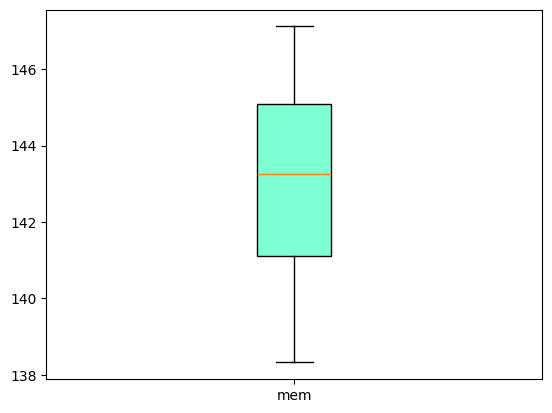

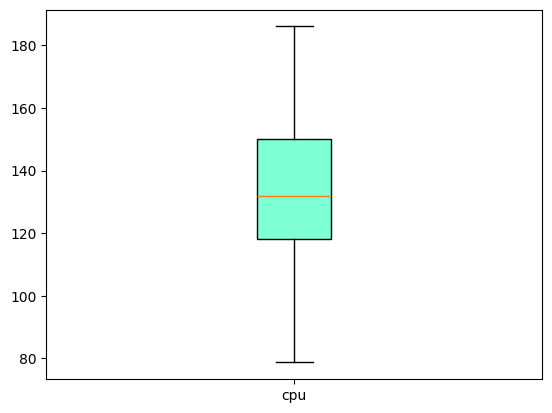

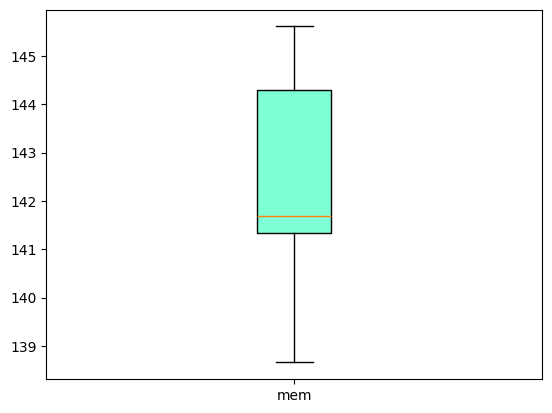

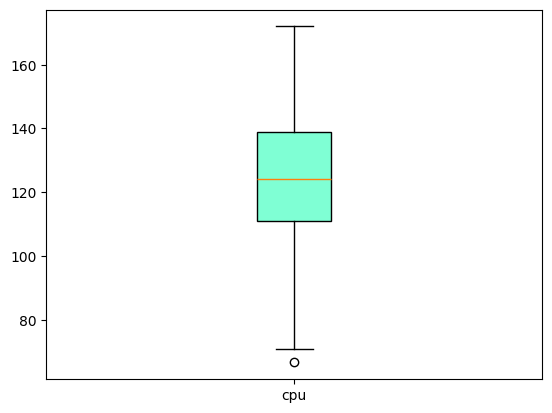

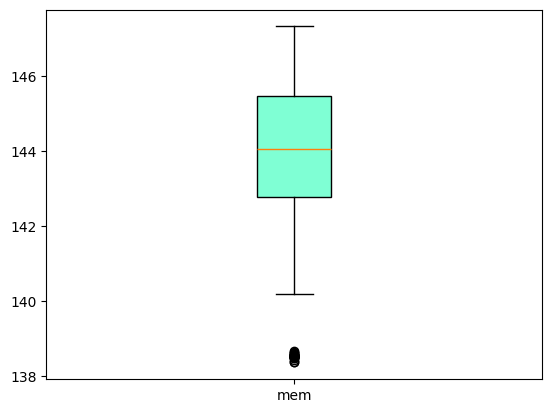

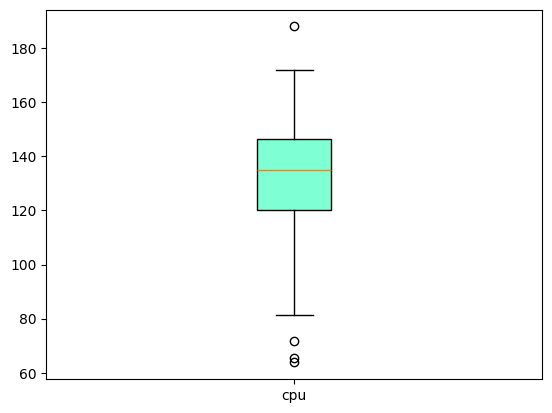

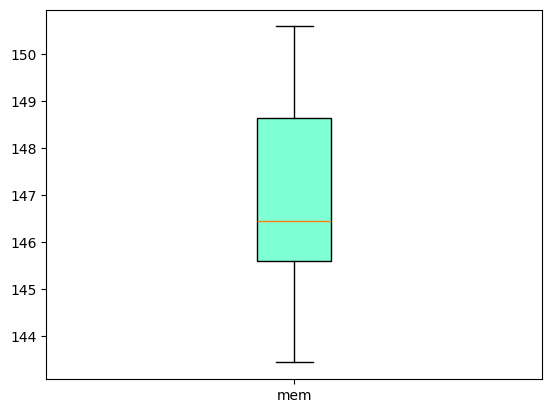

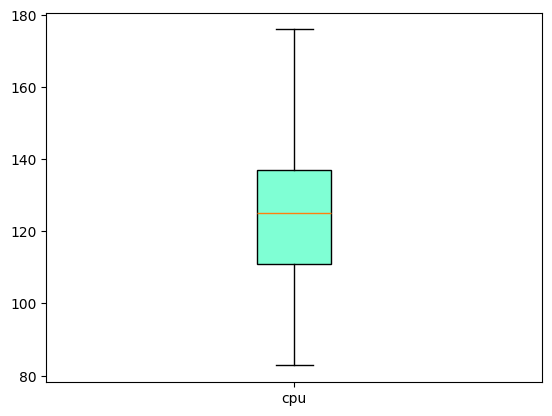

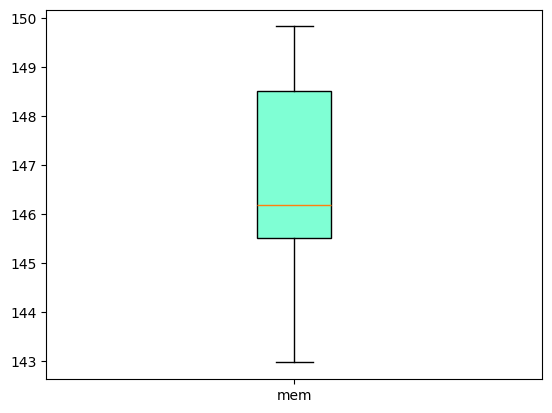

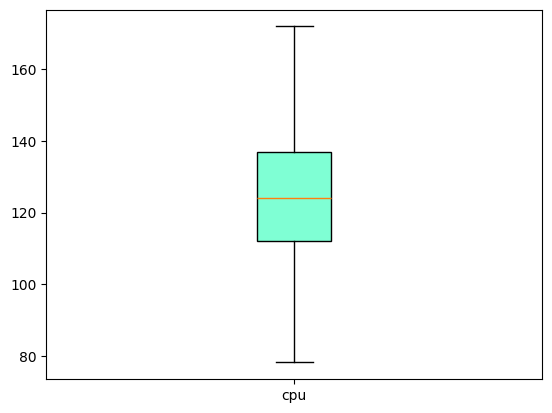

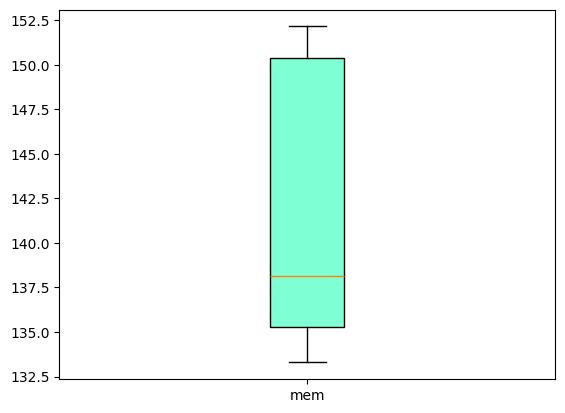

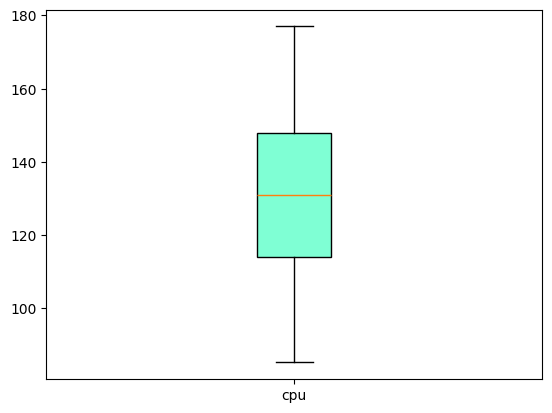

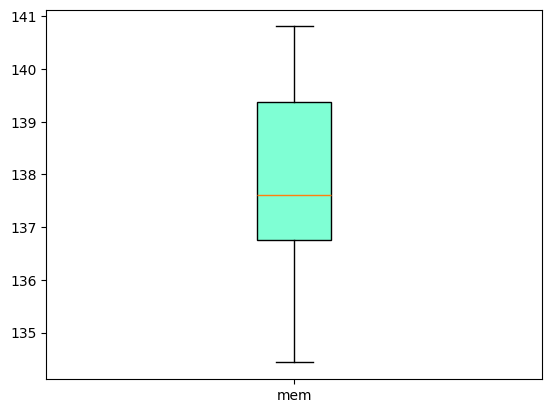

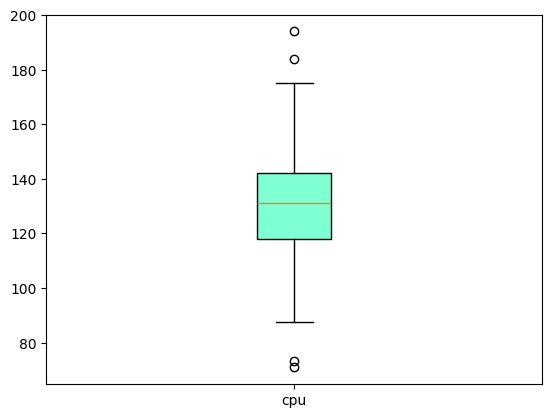

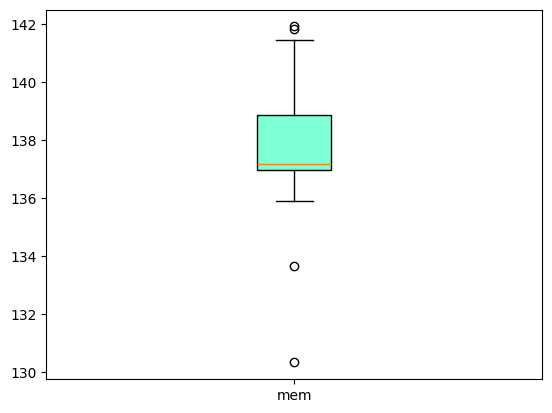

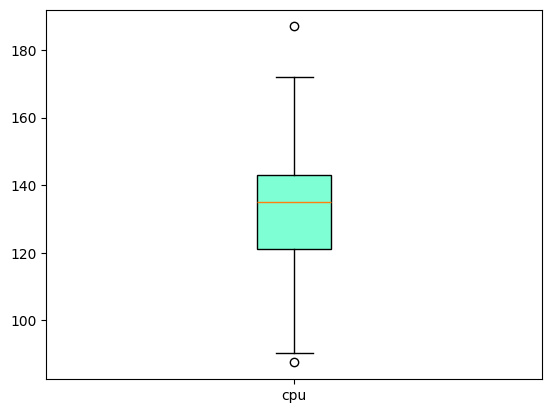

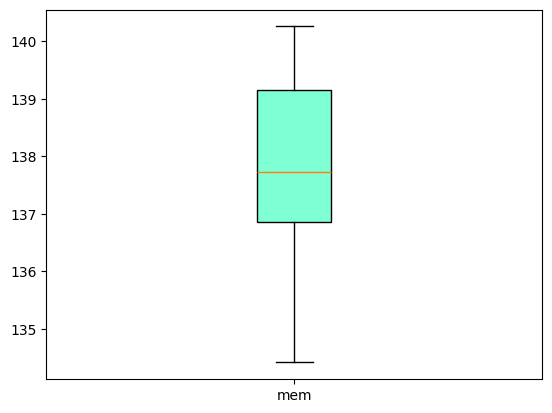

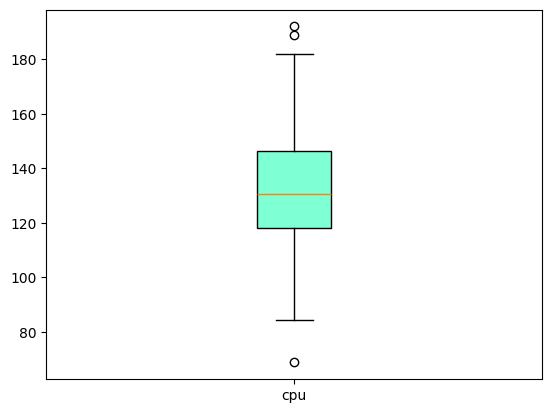

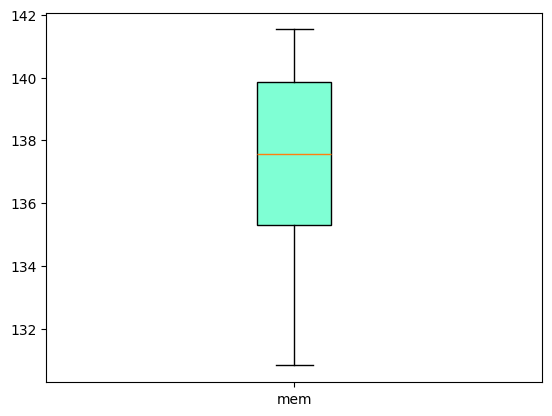

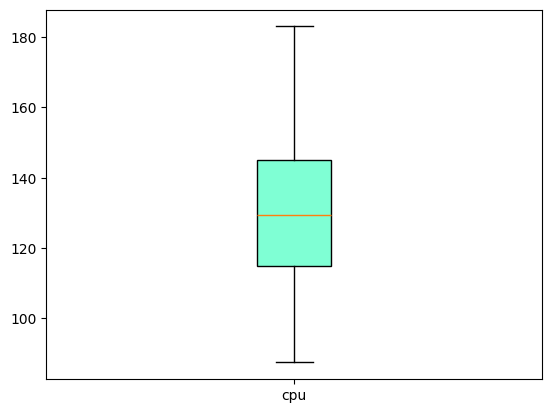

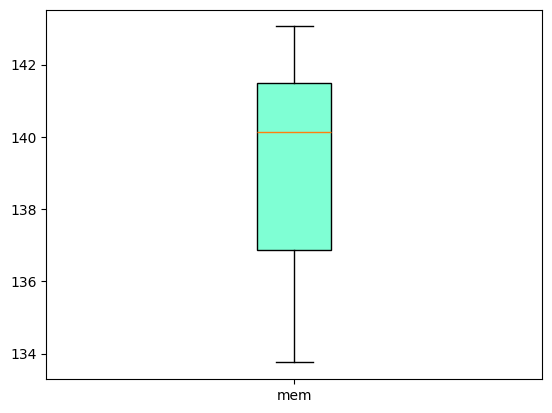

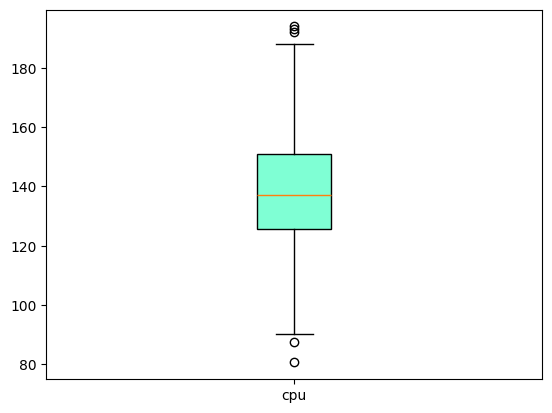

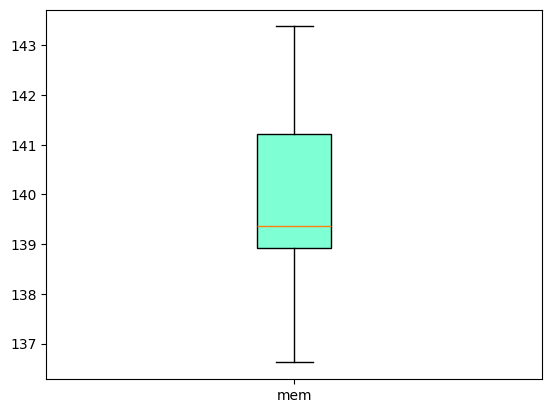

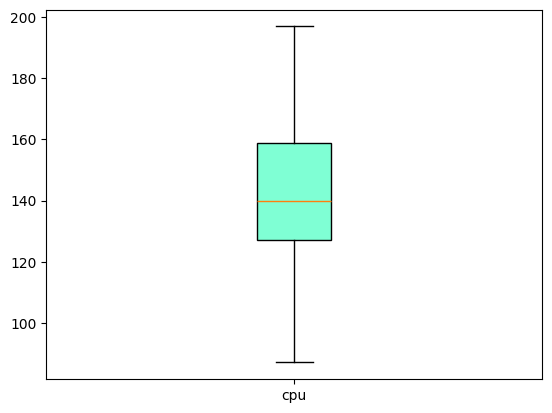

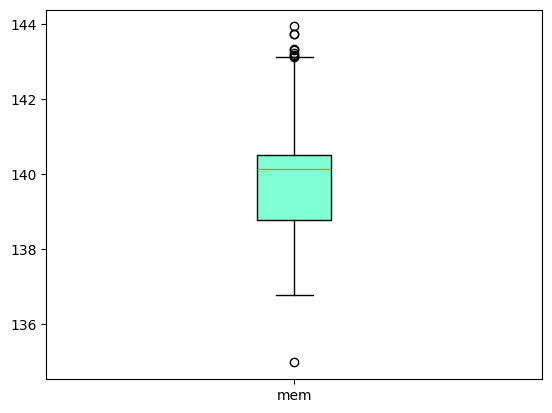

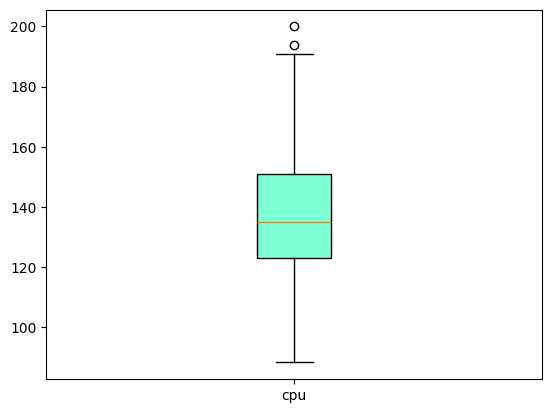

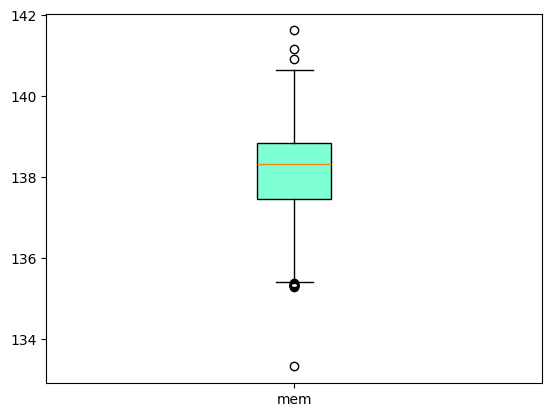

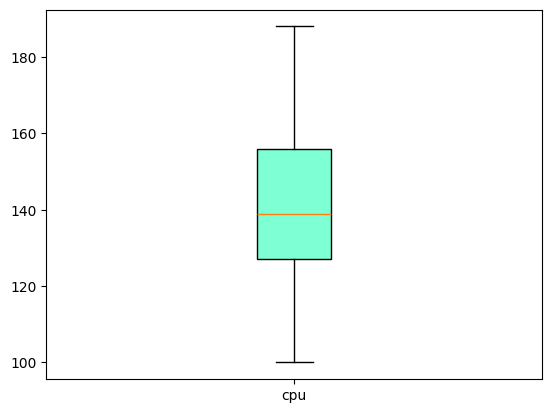

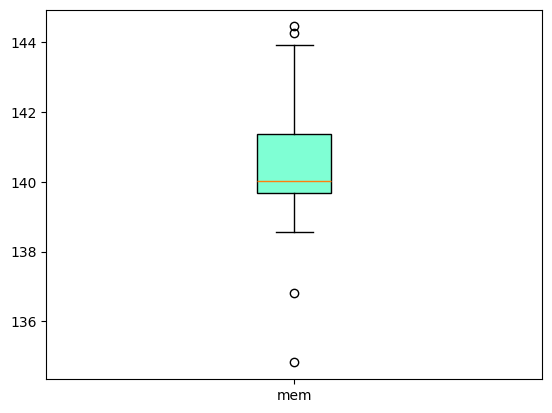

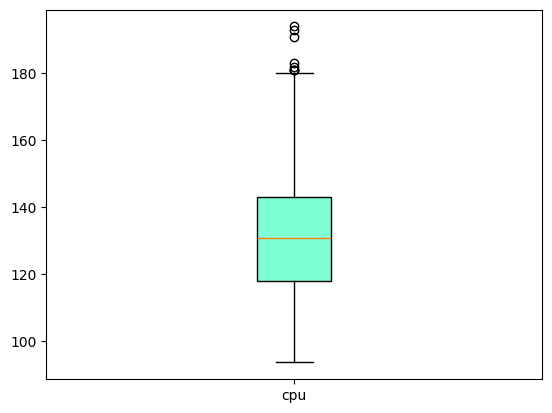

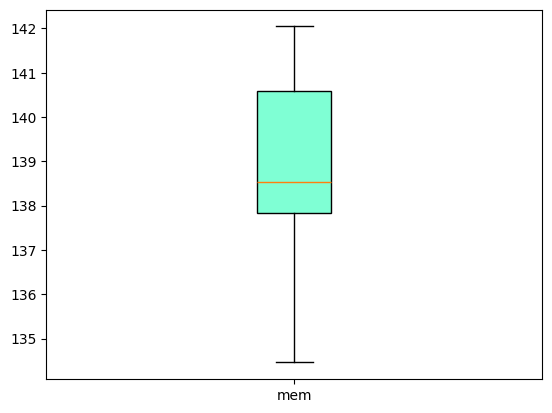

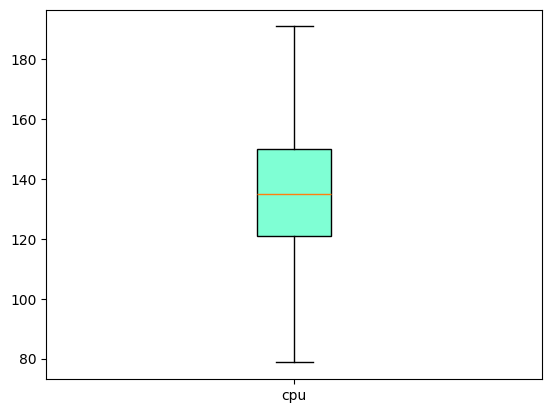

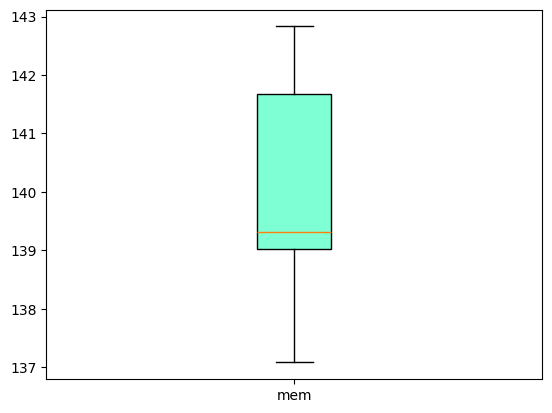

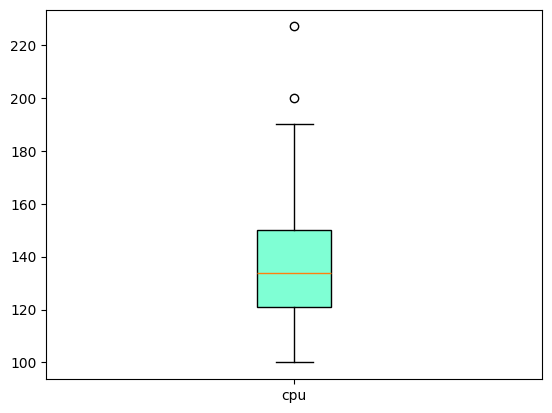

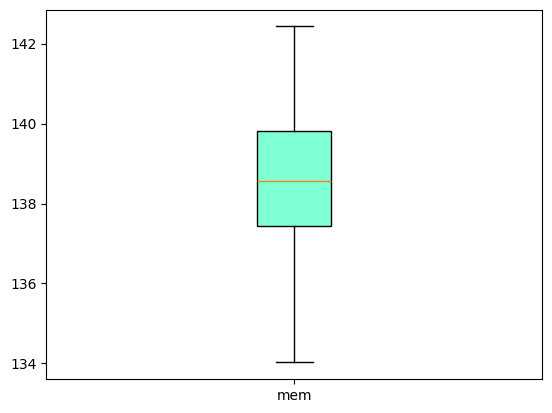

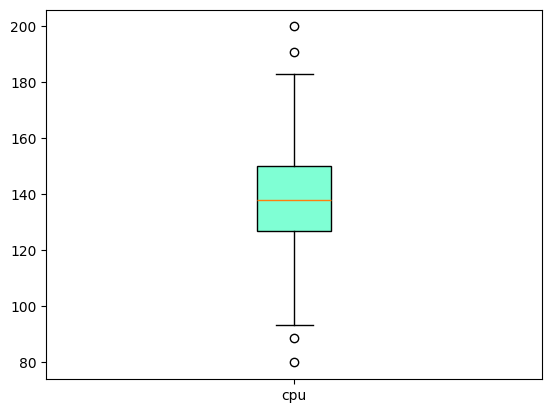

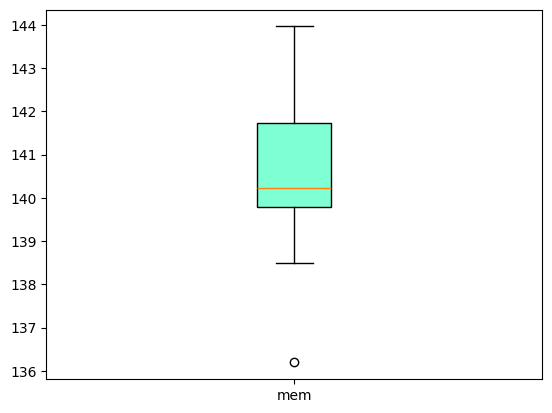

In [33]:
for version in ["1.3", "1.5"]:
    os.makedirs(version, exist_ok=True)
    for stat in STAT_TYPE:
        os.makedirs(version + "/" + stat, exist_ok=True)
        for mode in ["normal", "plc"]:
            os.makedirs(version + "/" + stat + "/" + mode, exist_ok=True)


for version in ["1.3", "1.5"]:
    for complex in range(1,10+1):
        for mode in ["normal", "plc"]:
            for type in STAT_TYPE:
                data = getStatArray(complexity=complex, mode=mode, type=type, version=version)
                drawBoxPlot(data, complex, type, mode, version)